In [1]:
import numpy as np
from c2st.utils import GaussianData
from numpy.random import default_rng
RNG = default_rng(420)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from c2st.check import c2st
from sklearn.model_selection import KFold

In [23]:
%load_ext autoreload
%autoreload 2

In [2]:
data1 = GaussianData(
    [10, 20, 30],
    np.linspace(0,2,17),
    np.linspace(1,5,17),
    5000
)
data2 = GaussianData(
    [10, 20, 30],
    np.linspace(0,2,17),
    np.linspace(1,5,17),
    5000,
    seed=489 # to change sample values
)

In [3]:
data2.means

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
       1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   ])

In [4]:
data2.std_devs

array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
       3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])

In [5]:
(data1[10][(0., 1.0)] == data2[10][(0., 1.0)]).all()

False

In [11]:
mean_0_sdev_1 = np.copy(data2[10][(0., 1.0)])
print((mean_0_sdev_1[:,9] == data2[10][(0., 1.25)][:,9]).all())
mean_0_sdev_1[:,9] = data2[10][(0., 1.25)][:,9]
print((mean_0_sdev_1[:,9] == data2[10][(0., 1.25)][:,9]).all())

False
True


In [3]:
def permute(P, Q, title, plot=False, _c2st=True, save=False):
    data = np.concatenate((P, Q), axis=0)
    target = np.concatenate((np.zeros((P.shape[0],)), np.ones((Q.shape[0],))))
    X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target, random_state=42)

    feature_names = [f"dimension {i}" for i in range(data.shape[1])]
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X_train, y_train)
    test_acc = forest.score(X_test, y_test)
    result = permutation_importance(
        forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    feature_idx = np.argmax(result.importances_mean)
    feature_score = np.max(result.importances_mean)
    forest_importances = pd.Series(result.importances_mean, index=feature_names)
    
    # c2st
    if _c2st:
        c2st_score = c2st(P, Q, cv=KFold(n_splits=3, shuffle=True, random_state=1))
        print(f"c2st: {c2st_score} test acc: {test_acc}")
    
    # plotting
    if plot:
        fig, ax = plt.subplots()
        forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
        ax.set_title(title)
        ax.set_ylabel("Mean accuracy decrease")
        fig.tight_layout()
        if save:
            plt.savefig(f"{title}.png")
        plt.show()
    
    return feature_idx, feature_score    

c2st: 0.5282487233718934 test acc: 0.524
1.25: idx 9 | score 0.030840000000000024
c2st: 0.5584646243525969 test acc: 0.554
1.5: idx 9 | score 0.06084000000000006
c2st: 0.608111231217129 test acc: 0.6052
1.75: idx 9 | score 0.10735999999999994
c2st: 0.6284988087670228 test acc: 0.6204
2.0: idx 9 | score 0.12151999999999993
c2st: 0.6618338734823638 test acc: 0.6496
2.25: idx 9 | score 0.14939999999999995
c2st: 0.6845891502724587 test acc: 0.6836
2.5: idx 9 | score 0.18591999999999995
c2st: 0.7073535548120676 test acc: 0.7064
2.75: idx 9 | score 0.20768000000000003
c2st: 0.725075174747797 test acc: 0.7156
3.0: idx 9 | score 0.21700000000000003
c2st: 0.7408334986060066 test acc: 0.728
3.25: idx 9 | score 0.23051999999999997
c2st: 0.7512113804575525 test acc: 0.7488
3.5: idx 9 | score 0.25336000000000003
c2st: 0.7694231164202359 test acc: 0.7744
3.75: idx 9 | score 0.27447999999999995
c2st: 0.7782416005093888 test acc: 0.7708
4.0: idx 9 | score 0.2705200000000001
c2st: 0.7891711530350797 te

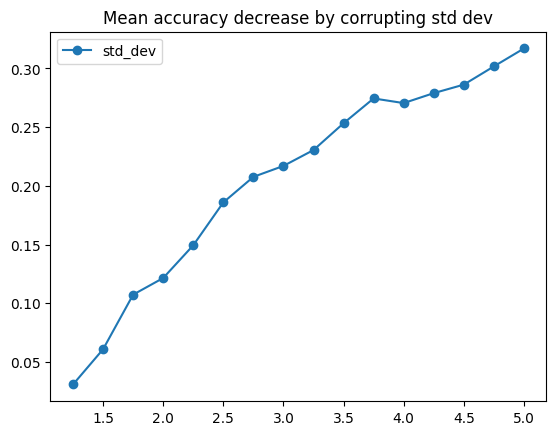

In [4]:
scores = []
for std_dev in data2.std_devs[1:]:
    corrupted = np.copy(data2[10][(0., 1.0)])
    corrupted[:,9] = data2[10][(0., std_dev)][:,9]
    idx, score = permute(data1[10][(0., 1.0)], corrupted, '')
    print(f"{std_dev}: idx {idx} | score {score}")
    scores.append(score)

plt.plot(data2.std_devs[1:], scores, '-o', label="std_dev")
plt.legend(loc="upper left")
plt.title("Mean accuracy decrease by corrupting std dev")
plt.savefig("std_dev.png")
plt.show()

c2st: 0.5114670930242715 test acc: 0.5092
0.125: idx 9 | gini 0.015359999999999985 | c2st 0.5114670930242715
c2st: 0.5310370014931659 test acc: 0.5364
0.25: idx 9 | gini 0.030919999999999975 | c2st 0.5310370014931659
c2st: 0.5473115478553571 test acc: 0.5376
0.375: idx 9 | gini 0.03187999999999998 | c2st 0.5473115478553571
c2st: 0.5787612765859868 test acc: 0.5804
0.5: idx 9 | gini 0.08008000000000001 | c2st 0.5787612765859868
c2st: 0.609467087064553 test acc: 0.602
0.625: idx 9 | gini 0.10152000000000001 | c2st 0.609467087064553
c2st: 0.6365016285745999 test acc: 0.6232
0.75: idx 9 | gini 0.12399999999999997 | c2st 0.6365016285745999
c2st: 0.651253665392051 test acc: 0.6592
0.875: idx 9 | gini 0.15564000000000003 | c2st 0.651253665392051
c2st: 0.6824890913037959 test acc: 0.6776
1.0: idx 9 | gini 0.17979999999999996 | c2st 0.6824890913037959
c2st: 0.7055920043080643 test acc: 0.6964
1.125: idx 9 | gini 0.19712000000000002 | c2st 0.7055920043080643
c2st: 0.729547962896438 test acc: 0.7

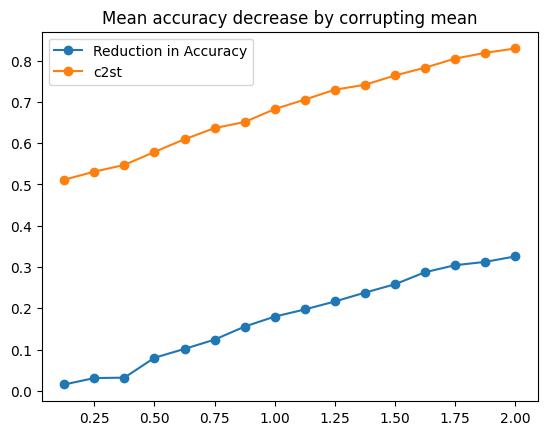

In [5]:
acc_scores = []
c2st_scores = []
for mean in data2.means[1:]:
    corrupted = np.copy(data2[10][(0., 1.0)])
    corrupted[:,9] = data2[10][(mean, 1.0)][:,9]
    idx, acc_score = permute(data1[10][(0., 1.0)], corrupted, '')
    c2st_score = c2st(data1[10][(0., 1.0)],  corrupted, cv=KFold(n_splits=3, shuffle=True, random_state=1))
    print(f"{mean}: idx {idx} | gini {acc_score} | c2st {c2st_score}")
    acc_scores.append(acc_score)
    c2st_scores.append(c2st_score)

plt.plot(data2.means[1:], acc_scores, '-o', label="Reduction in Accuracy")
plt.plot(data2.means[1:], c2st_scores, '-o', label="c2st")
plt.legend(loc="upper left")
plt.title("Mean accuracy decrease by corrupting mean")
plt.savefig("mean.png")
plt.show()

c2st: 0.49771298111812823


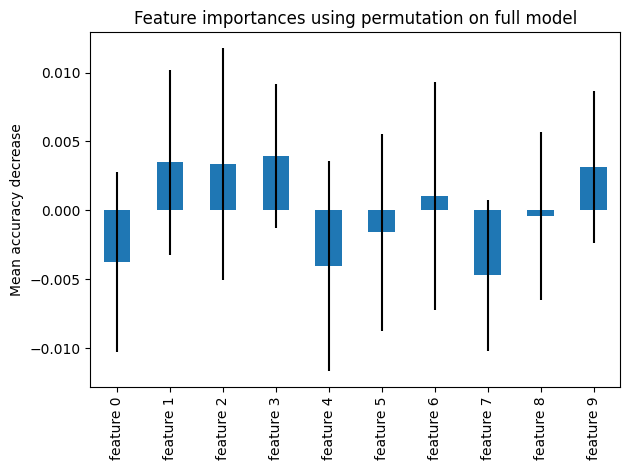

(3, 0.003920000000000007)

In [9]:
permute(data1[10][(0., 1.0)], data2[10][(0., 1.0)], plot=True)

# Results

c2st: 0.49771298111812823 test acc: 0.4984


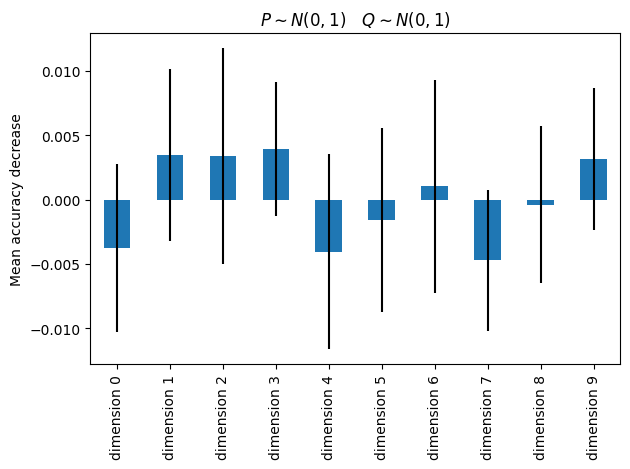

(3, 0.003920000000000007)

In [6]:
permute(
    data1[10][(0., 1.0)], 
    data2[10][(0., 1.0)], 
    r'$P \sim N(0,1) \quad Q \sim N(0,1)$',
    plot=True,
    save=True
)

c2st: 0.6776391315221234 test acc: 0.662


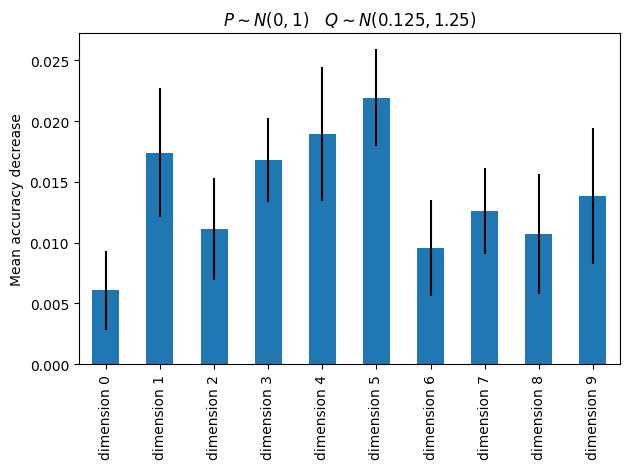

(5, 0.02192000000000003)

In [11]:
permute(
    data1[10][(0., 1.0)], 
    data2[10][(0.125, 1.25)], 
    r'$P \sim N(0,1) \quad Q \sim N(0.125,1.25)$',
    plot=True,
    save=True
)

c2st: 0.5282487233718934 test acc: 0.524


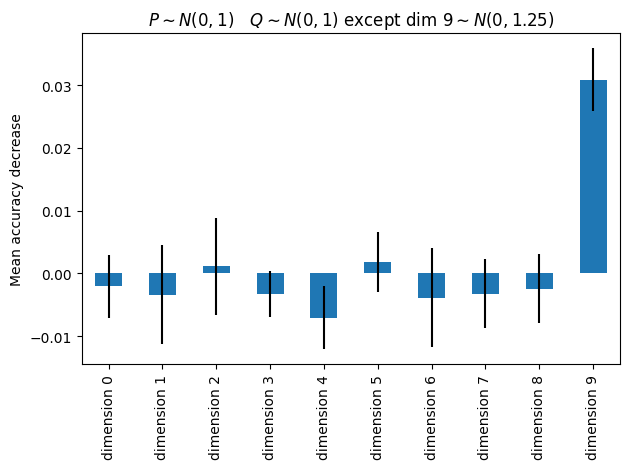

(9, 0.030840000000000024)

In [12]:
corrupted = np.copy(data2[10][(0., 1.0)])
corrupted[:,9] = data2[10][(0., 1.25)][:,9]
#corrupted[:,8] = data2[10][(0., 1.5)][:,8]
#corrupted[:,7] = data2[10][(0.125, 1.0)][:,7]
#corrupted[:,6] = data2[10][(0.25, 1.0)][:,6]
permute(
    data1[10][(0., 1.0)], 
    corrupted, 
    r'$P \sim N(0,1) \quad Q \sim N(0,1)$ except dim 9$\sim N(0,1.25)$',
    plot=True,
    save=True
)

c2st: 0.5929350825671362 test acc: 0.592


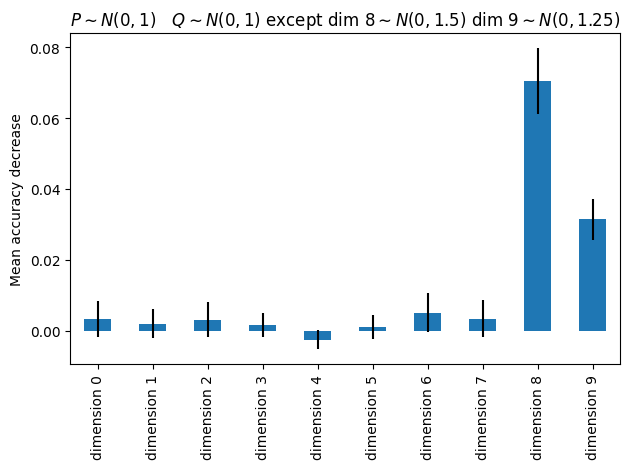

(8, 0.07043999999999997)

In [13]:
corrupted = np.copy(data2[10][(0., 1.0)])
corrupted[:,9] = data2[10][(0., 1.25)][:,9]
corrupted[:,8] = data2[10][(0., 1.5)][:,8]

permute(
    data1[10][(0., 1.0)], 
    corrupted, 
    r'$P \sim N(0,1) \quad Q \sim N(0,1)$ except dim 8$\sim N(0,1.5)$ dim 9$\sim N(0,1.25)$',
    plot=True,
    save=True
)

c2st: 0.5280693808762135 test acc: 0.5264


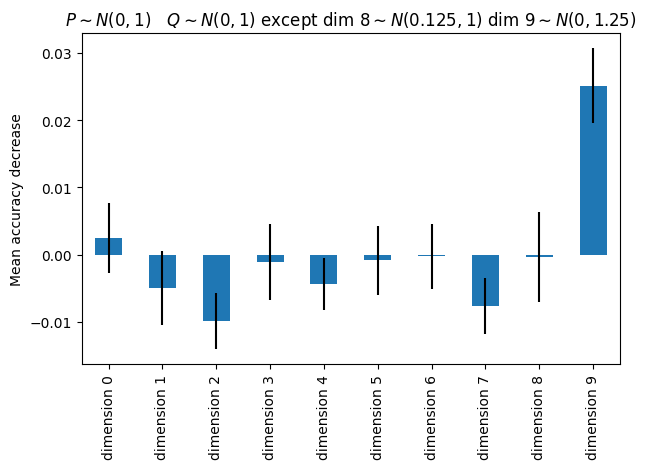

(9, 0.02511999999999997)

In [14]:
corrupted = np.copy(data2[10][(0., 1.0)])
corrupted[:,9] = data2[10][(0., 1.25)][:,9]
corrupted[:,8] = data2[10][(0.125, 1.0)][:,8]

permute(
    data1[10][(0., 1.0)], 
    corrupted, 
    r'$P \sim N(0,1) \quad Q \sim N(0,1)$ except dim 8$\sim N(0.125,1)$ dim 9$\sim N(0,1.25)$',
    plot=True,
    save=True
)

c2st: 0.5114670930242715 test acc: 0.5092


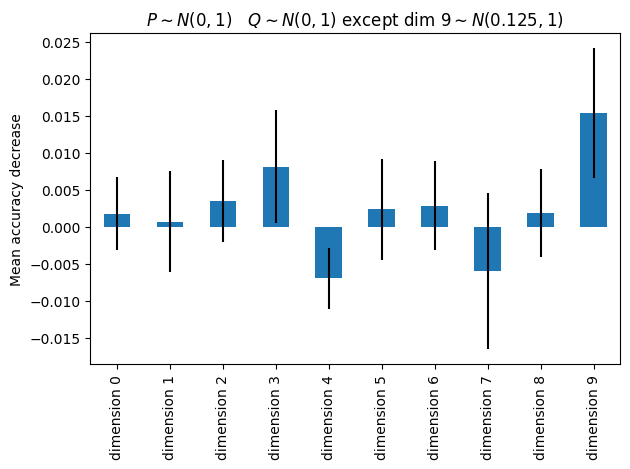

(9, 0.015359999999999985)

In [15]:
corrupted = np.copy(data2[10][(0., 1.0)])
corrupted[:,9] = data2[10][(0.125, 1.0)][:,9]

permute(
    data1[10][(0., 1.0)], 
    corrupted, 
    r'$P \sim N(0,1) \quad Q \sim N(0,1)$ except dim 9$\sim N(0.125,1)$',
    plot=True,
    save=True
)

c2st: 0.5310370014931659 test acc: 0.5364


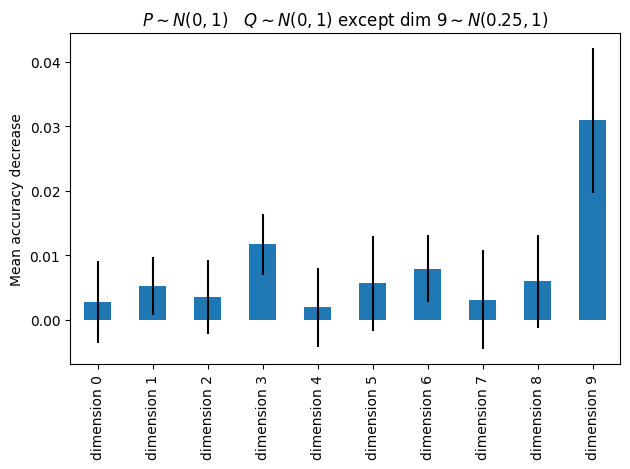

(9, 0.030919999999999975)

In [16]:
corrupted = np.copy(data2[10][(0., 1.0)])
corrupted[:,9] = data2[10][(0.25, 1.0)][:,9]

permute(
    data1[10][(0., 1.0)], 
    corrupted, 
    r'$P \sim N(0,1) \quad Q \sim N(0,1)$ except dim 9$\sim N(0.25,1)$',
    plot=True,
    save=True
)